In [1]:
%load_ext autoreload
%autoreload 2
import torch

import os
import sys
module_path = os.path.abspath(os.path.join('../../../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load models

In [2]:
from classification.models.SpectrogramCNN_8K_Dataset2 import SpectrogramCNN_8K_Dataset2_PLModule

state_dict_path = "/nfs/students/summer-term-2020/project-4/SAVED_MODELS/SpectrogramCNN_8K_Dataset2/optuna_spec8kd2_0.90.p"

state_dict = torch.load(state_dict_path)

model = SpectrogramCNN_8K_Dataset2_PLModule(state_dict['hparams'])
model.model.load_state_dict(state_dict['state_dict'])
model = model.cuda()
model = model.eval()

# Load Data

In [3]:
from datasets.datasethandler import DatasetHandler
datasetHandler = DatasetHandler()

In [4]:
import config
datasetHandler.load(model, 'validation', dataset_id=config.DATASET_CONTROL)
datasetHandler.load(model, 'training', dataset_id=config.DATASET_CONTROL)

Loading cached validation data of dataset 1 from /nfs/students/summer-term-2020/project-4/data/dataset2/dataset_8k/
Loading cached training data of dataset 1 from /nfs/students/summer-term-2020/project-4/data/dataset2/dataset_8k/


# Attacks

In [9]:
epsilons = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005]

## Simple PGD

In [10]:
from attacks.pgd import ProjectedGradientDescent

pgd_attacks = {}

for eps in epsilons:
    attack_parameters = {'epsilon': eps, 'num_iter': 50}
    pgd = ProjectedGradientDescent(model, model.val_dataloader(), attack_parameters, save_samples=False)
    pgd.attack()
    print(pgd.getSuccessRate())
    pgd_attacks[eps] = pgd

100%|██████████| 57/57 [02:10<00:00,  2.29s/it]

0.521395655036208



100%|██████████| 57/57 [02:04<00:00,  2.19s/it]

0.7254772876892692



100%|██████████| 57/57 [02:05<00:00,  2.19s/it]

0.8242264647794602



100%|██████████| 57/57 [02:05<00:00,  2.20s/it]

0.8894009216589862



100%|██████████| 57/57 [02:05<00:00,  2.20s/it]

0.9223173140223832


In [11]:
for eps in pgd_attacks:
    pgd_attacks[eps].report()
    print()

Attack-Parameters:	{'epsilon': 0.0001, 'num_iter': 50}
Early stopping: 	False (-1)

Successfully attacked:	792
Total attacked: 	1519
Total processed:	1687

Success-Rate: 		0.52
Perturbed Accurracy: 	0.43

Attack-Parameters:	{'epsilon': 0.0002, 'num_iter': 50}
Early stopping: 	False (-1)

Successfully attacked:	1102
Total attacked: 	1519
Total processed:	1687

Success-Rate: 		0.73
Perturbed Accurracy: 	0.25

Attack-Parameters:	{'epsilon': 0.0003, 'num_iter': 50}
Early stopping: 	False (-1)

Successfully attacked:	1252
Total attacked: 	1519
Total processed:	1687

Success-Rate: 		0.82
Perturbed Accurracy: 	0.16

Attack-Parameters:	{'epsilon': 0.0004, 'num_iter': 50}
Early stopping: 	False (-1)

Successfully attacked:	1351
Total attacked: 	1519
Total processed:	1687

Success-Rate: 		0.89
Perturbed Accurracy: 	0.1

Attack-Parameters:	{'epsilon': 0.0005, 'num_iter': 50}
Early stopping: 	False (-1)

Successfully attacked:	1401
Total attacked: 	1519
Total processed:	1687

Success-Rate: 		0.92


## Functional Attack: PGD + Volume Attack

In [12]:
from attacks.functionalVolume import FunctionalVolumeAttack

functional_volume_attacks = {}

for eps in epsilons:
    attack_parameters = {'epsilonVolume': 0.1, 'epsilonPGD': eps, 'num_iter': 50}
    fva = FunctionalVolumeAttack(model, model.val_dataloader(), attack_parameters, save_samples=True)
    fva.attack()
    functional_volume_attacks[eps] = fva

100%|██████████| 57/57 [02:08<00:00,  2.25s/it]


In [13]:
for eps in functional_volume_attacks:
    print(eps)
    functional_volume_attacks[eps].report()
    print()

0.0001
Attack-Parameters:	{'epsilonVolume': 0.1, 'epsilonPGD': 0.0001, 'num_iter': 50}
Early stopping: 	False (-1)

Successfully attacked:	1185
Total attacked: 	1519
Total processed:	1687

Success-Rate: 		0.78
Perturbed Accurracy: 	0.2

0.0002
Attack-Parameters:	{'epsilonVolume': 0.1, 'epsilonPGD': 0.0002, 'num_iter': 50}
Early stopping: 	False (-1)

Successfully attacked:	1368
Total attacked: 	1519
Total processed:	1687

Success-Rate: 		0.9
Perturbed Accurracy: 	0.09

0.0003
Attack-Parameters:	{'epsilonVolume': 0.1, 'epsilonPGD': 0.0003, 'num_iter': 50}
Early stopping: 	False (-1)

Successfully attacked:	1438
Total attacked: 	1519
Total processed:	1687

Success-Rate: 		0.95
Perturbed Accurracy: 	0.05

0.0004
Attack-Parameters:	{'epsilonVolume': 0.1, 'epsilonPGD': 0.0004, 'num_iter': 50}
Early stopping: 	False (-1)

Successfully attacked:	1478
Total attacked: 	1519
Total processed:	1687

Success-Rate: 		0.97
Perturbed Accurracy: 	0.02

0.0005
Attack-Parameters:	{'epsilonVolume': 0.1, '

In [14]:
# functional_attacks[0.0003].showAdversarialExample(target_class=1)

## Functional Interpolation (imperceptible)

In [15]:
import random
import IPython.display as ipd

random_sample_index = random.sample(range(len(model.dataset['training'])), 1)[0]
random_sample_index = 2464 # manually picked
random_sample = model.dataset['training'].__getitem__(random_sample_index)

In [24]:
model.dataset['training'][random_sample_index]

{'audio': tensor([-0.0330, -0.1363, -0.1582,  ...,  0.0000,  0.0000,  0.0000]),
 'sample_rate': 8000,
 'label': 0}

In [16]:
from attacks.functionalInterpolation import FunctionalInterpolationAttack

functional_interpolation_attacks_imperceptible = {}

for eps in epsilons:
    attack_parameters = {'overlay_sound': random_sample,
                         'epsilonInterpolation': 0.1, 'epsilonNoise': eps, 'num_iter': 50, 
                         }
    fva = FunctionalInterpolationAttack(model, model.val_dataloader(), attack_parameters, save_samples=True)
    fva.attack()
    functional_interpolation_attacks_imperceptible[eps] = fva

  7%|▋         | 4/57 [00:10<02:22,  2.69s/it]


KeyboardInterrupt: 

In [16]:
for eps in functional_interpolation_attacks_imperceptible:
    functional_interpolation_attacks_imperceptible[eps].report()
    print()

Attack-Parameters:	{'overlay_sound': {'audio': tensor([-0.0194, -0.0101, -0.0441,  ...,  0.0000,  0.0000,  0.0000]), 'sample_rate': 48000, 'label': 0}, 'epsilonInterpolation': 0.1, 'epsilonNoise': 0.0001, 'num_iter': 50}
Early stopping: 	False (-1)

Successfully attacked:	506
Total attacked: 	1483
Total processed:	1687

Success-Rate: 		0.34
Perturbed Accurracy: 	0.58

Attack-Parameters:	{'overlay_sound': {'audio': tensor([-0.0194, -0.0101, -0.0441,  ...,  0.0000,  0.0000,  0.0000]), 'sample_rate': 48000, 'label': 0}, 'epsilonInterpolation': 0.1, 'epsilonNoise': 0.0002, 'num_iter': 50}
Early stopping: 	False (-1)

Successfully attacked:	908
Total attacked: 	1483
Total processed:	1687

Success-Rate: 		0.61
Perturbed Accurracy: 	0.34

Attack-Parameters:	{'overlay_sound': {'audio': tensor([-0.0194, -0.0101, -0.0441,  ...,  0.0000,  0.0000,  0.0000]), 'sample_rate': 48000, 'label': 0}, 'epsilonInterpolation': 0.1, 'epsilonNoise': 0.0003, 'num_iter': 50}
Early stopping: 	False (-1)

Successf

In [113]:
#ipd.display(ipd.Audio(random_sample['audio'], rate=random_sample['sample_rate']))
#functional_interpolation_attacks_imperceptible[0.0001].showAdversarialExample(target_class=1)

In [112]:
#ipd.display(ipd.Audio(random_sample['audio'], rate=random_sample['sample_rate']))
#functional_interpolation_attacks_imperceptible[0.0005].showAdversarialExample(target_class=1)

## Functional Interpolation (hearable)

In [17]:
import random
import IPython.display as ipd

random_sample_index = random.sample(range(len(model.dataset['training'])), 1)[0]
random_sample_index = 2464 # manually picked
random_sample = model.dataset['training'].__getitem__(random_sample_index)

In [18]:
from attacks.functionalInterpolation import FunctionalInterpolationAttack

functional_interpolation_attacks = {}

for eps in epsilons:
    attack_parameters = {'overlay_sound': random_sample,
                         'epsilonInterpolation': 0.1, 'epsilonNoise': eps, 'num_iter': 50, 
                         'upper2': 1,
                         }
    fva = FunctionalInterpolationAttack(model, model.val_dataloader(), attack_parameters, save_samples=True)
    fva.attack()
    functional_interpolation_attacks[eps] = fva

100%|██████████| 338/338 [08:47<00:00,  1.56s/it]


In [111]:
#ipd.display(ipd.Audio(random_sample['audio'], rate=random_sample['sample_rate']))
#functional_interpolation_attacks[0.0001].showAdversarialExample(target_class=1)

In [110]:
#ipd.display(ipd.Audio(random_sample['audio'], rate=random_sample['sample_rate']))
#functional_interpolation_attacks[0.0005].showAdversarialExample(target_class=1)

In [ ]:
for eps in functional_interpolation_attacks:
    functional_interpolation_attacks[eps].report()
    print()

## Functional Time-stretching Attacks

In [20]:
from attacks.functionalSpeed import FunctionalTimeStretchAttack

functional_time_stretching_attacks = {}

for eps in epsilons:
    attack_parameters = {'epsilon': eps, 'num_iter': 50, 'num_iter_stretch': 4}
    fpg = FunctionalTimeStretchAttack(model, model.val_dataloader(), attack_parameters, save_samples=True)
    fpg.attack()
    functional_time_stretching_attacks[eps] = fpg

100%|██████████| 338/338 [08:56<00:00,  1.59s/it]


In [21]:
for eps in functional_time_stretching_attacks:
    functional_time_stretching_attacks[eps].report()
    print()

Attack-Parameters:	{'epsilon': 0.0001, 'num_iter': 50, 'num_iter_stretch': 4}
Early stopping: 	False (-1)

Successfully attacked:	520
Total attacked: 	1483
Total processed:	1687

Success-Rate: 		0.35
Perturbed Accurracy: 	0.57

Attack-Parameters:	{'epsilon': 0.0002, 'num_iter': 50, 'num_iter_stretch': 4}
Early stopping: 	False (-1)

Successfully attacked:	930
Total attacked: 	1483
Total processed:	1687

Success-Rate: 		0.63
Perturbed Accurracy: 	0.33

Attack-Parameters:	{'epsilon': 0.0003, 'num_iter': 50, 'num_iter_stretch': 4}
Early stopping: 	False (-1)

Successfully attacked:	1021
Total attacked: 	1483
Total processed:	1687

Success-Rate: 		0.69
Perturbed Accurracy: 	0.27

Attack-Parameters:	{'epsilon': 0.0004, 'num_iter': 50, 'num_iter_stretch': 4}
Early stopping: 	False (-1)

Successfully attacked:	1034
Total attacked: 	1483
Total processed:	1687

Success-Rate: 		0.7
Perturbed Accurracy: 	0.27

Attack-Parameters:	{'epsilon': 0.0005, 'num_iter': 50, 'num_iter_stretch': 4}
Early sto

In [180]:
# functional_time_stretching_attacks[0.0005].showAdversarialExample(target_class=1)

## Functional Pitch-Shifting Attacks

In [126]:
from attacks.functionalPitch import FunctionalPitchAttack

functional_pitch_shifting_attacks = {}

for eps in [0.0005]:
    attack_parameters = {'epsilon': eps, 'num_iter': 50, 'num_iter_stretch': 4}
    fpg = FunctionalPitchAttack(model, model.val_dataloader(), attack_parameters, save_samples=False)
    fpg.attack()
    functional_pitch_shifting_attacks[eps] = fpg

  3%|▎         | 9/338 [03:29<2:07:21, 23.23s/it]


KeyboardInterrupt: 

# Visualization

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
def draw_plot(x = [1,2,3], data = [{"data": [0.1, 0.33, 0.5], "color" : "r", "label": "test"}], x_label = "x-axis", y_label = "y-axis", title = "Title", save_path=None,legend_title="Legend",legend_x_offset=1.3):
    
    sns.set()
    sns.set_style("whitegrid")
    sns.set_context("poster")
    
    # create an index for each tick position
    xi = list(range(len(x)))

    # create plot
    f = plt.figure(figsize=(10,8))

    # y-axis: 
    plt.ylim(0.,1)
    plt.yticks(np.arange(0, 1.01, 0.1))

    for d in data:
        plt.plot(xi, d["data"], marker='o', linestyle='-', color=d["color"], label=d["label"]) 

    plt.xlabel(x_label)
    plt.ylabel(y_label) 
    plt.xticks(xi, x)
    plt.title(title,fontsize=35)
    plt.legend() 
    plt.xticks(xi)
    leg = plt.legend(loc='center right', bbox_to_anchor=(legend_x_offset, 0.5), ncol=1, frameon=False, title=legend_title)
    leg._legend_box.align = "left"
    plt.show()

In [43]:
y1 = {'data': [pgd_attacks[attack_id].getSuccessRate() for attack_id in pgd_attacks]}
y1['color'] = 'b'
y1['label'] = "Adding noise"

y2 = {'data': [functional_volume_attacks[attack_id].getSuccessRate() for attack_id in functional_volume_attacks]}
y2['color'] = 'r'
y2['label'] = "Adding noise + Changing Volume"

y3 = {'data': [functional_interpolation_attacks[attack_id].getSuccessRate() for attack_id in functional_interpolation_attacks]}
y3['color'] = 'orange'
y3['label'] = "Adding noise + Changing Volume + Overlaying (perceptible)"

y4 = {'data': [functional_interpolation_attacks_imperceptible[attack_id].getSuccessRate() for attack_id in functional_interpolation_attacks_imperceptible]}
y4['color'] = 'g'
y4['label'] = "Adding noise + Changing Volume + Overlaying (imperceptible)"

y5 = {'data': [functional_time_stretching_attacks[attack_id].getSuccessRate() for attack_id in functional_time_stretching_attacks]}
y5['color'] = 'grey'
y5['label'] = "Adding noise + Time Stretching"

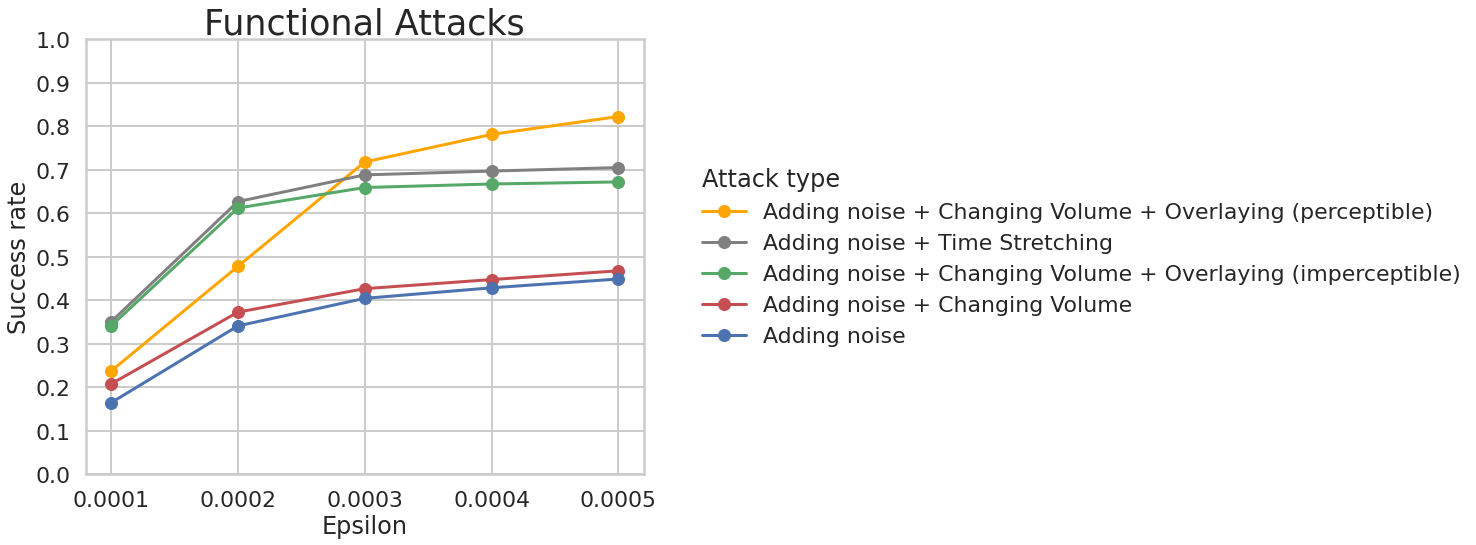

In [46]:
draw_plot(epsilons, data = [y3, y5, y4, y2, y1 ], legend_x_offset=2.5, title="Functional Attacks",
          legend_title="Attack type", x_label="Epsilon", y_label="Success rate")